## <center> <font color='Green'>Прогнозирование продаж магазинов</font>
Автор материала: ***Гольский Владимир Николаевич***

e-mail: v.golskiy@yandex.ru

### План.
1. Описание набора данных и решаемой задачи
2. Первичный и визуальный анализ данных
3. Построение новых признаков
4. Корреляционный анализ признаков
6. Выбор и обучение модели
8. ...
... Выводы.

## 1. Описание набора данных и решаемая задача

### Формулировка задачи
Данные содержат информацию о продажах в сети магазинов в одном городе за несколько лет. В магазинах периодически проводятся рекламные акции.

**Задание:**
- Построить прогноз продаж за период 2017-2018 при условии известного графика рекламных акций
- Сделать анализ того, насколько реклама влияет на продажи в магазинах

### Описание данных

Датасет представлен в виде csv-файлов с данными по 8 магазинам для построения train и test-выборки. Для каждого из магазинов:
- Train-выборка включает 2921 запись
- Test-выборка включает 729 записей

Описание данных:
- Целевая переменная - индекс продаж в магазине в разрезе дней за период 2008-2015 гг.
- Имеющаяся информация:
    - **date** - дата сбора данных по продажам/наличию рекламных акций
    - **advert_train** - рекламные акции в магазинах (обозначены 1 в соответствующую дату)
    - **sales_train** - индексы продаж по дням за период 2008 - 2015 (за точку начала осчета приняты продажи на начало указанного периода, поэтому индексы для магазинов начинаются с 1)
    - **advert_test** - рекламные акции в тестовом периоде

## 2. Первичный анализ данных 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import grid_search
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics
from sklearn.decomposition import PCA

#import lightgbm as lgb
#import xgboost as xgb

import pickle
import tqdm

from collections import Counter

import statsmodels.api as sm
from scipy.stats import shapiro

import warnings
warnings.simplefilter("ignore")

RANDOM_STATE=0

%pylab inline 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


Загрузка данных:

In [2]:
adv_train = pd.read_csv('advert_train.csv')
sal_train = pd.read_csv('sales_train.csv')
adv_test = pd.read_csv('advert_test.csv')
print (adv_train.shape, sal_train.shape, adv_test.shape)

(2921, 9) (2921, 9) (729, 9)


Создание обучающей и тестовой выборок из исходных данных:

In [3]:
train = pd.DataFrame()
for column in adv_train.iloc[:, 1:].columns:
    tmp = pd.concat([pd.to_datetime(adv_train['date']), 
                    pd.Series([int(column.split('_')[1])]*adv_train.shape[0]), 
                    pd.Series(adv_train[column].values),
                    sal_train[column]],
                    axis = 1)
    tmp.rename(columns = {0:'market', 1: 'advert', column: 'sales_indx'}, inplace=True)
    train = pd.concat([train, tmp])

print(train.shape)
train.head()

(23368, 4)


,date,market,advert,sales_indx
0,2008-01-02,1,0,1.000000
1,2008-01-03,1,0,NaN
2,2008-01-04,1,0,1.015188
3,2008-01-05,1,0,NaN
4,2008-01-06,1,0,0.995762


In [4]:
test = pd.DataFrame()
for column in adv_train.iloc[:, 1:].columns:
    tmp = pd.concat([pd.to_datetime(adv_test['date']), 
                    pd.Series([int(column.split('_')[1])]*adv_test.shape[0]), 
                    pd.Series(adv_test[column].values)],
                    axis = 1)
    tmp.rename(columns = {0:'market', 1: 'advert'}, inplace=True)
    test = pd.concat([test, tmp])

print(test.shape)
test.head()

(5832, 3)


,date,market,advert
0,2016-01-01,1,0
1,2016-01-02,1,0
2,2016-01-03,1,0
3,2016-01-04,1,0
4,2016-01-05,1,0


Информация по заполненности и типам данных для полученных таблиц:

In [5]:
print('Обучающая выборка:'); train.info(); print('\n\nТестовая выборка:'); test.info()

Обучающая выборка:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23368 entries, 0 to 2920
Data columns (total 4 columns):
date          23368 non-null datetime64[ns]
market        23368 non-null int64
advert        23368 non-null int64
sales_indx    18679 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 912.8 KB


Тестовая выборка:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5832 entries, 0 to 728
Data columns (total 3 columns):
date      5832 non-null datetime64[ns]
market    5832 non-null int64
advert    5832 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 182.2 KB


Исходя из того, что данные о наличии рекламных акций в магазинах имеются за каждый день (нет пропусков), считаем, что магазины работали постоянно. Для того, чтобы построить модель необходимо заполнить пропуски в данных по продажам. Заполнять данные будем по следующему принципу (в рамках каждого магазина):
- находим последнее заполненное значение до пропуска
- находим первое заполненное значение после пропуска
- вычисляем разницу между найденными значениями
- делим разницу на количество дней, в которые не отображены продажи
- прибавляем полученное частное к последнему заполненному значению для каждого дня пропуска накопительным итогом (предполагаем, что продажи изменялись равномерно в течение пропуска)

Первые четыре операции были выполнены в MS SQL Server (скрипт приложен), результаты работы срипта загружаем в рабочую книгу:

In [6]:
fill_na = pd.read_csv('Fill_NA.txt', sep = '\t')

In [7]:
fill_na.base_date = pd.to_datetime(fill_na.base_date)
fill_na.date_bfr = pd.to_datetime(fill_na.date_bfr)
fill_na.date_aftr = pd.to_datetime(fill_na.date_aftr) 

In [8]:
fill_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4689 entries, 0 to 4688
Data columns (total 9 columns):
market        4689 non-null int64
base_date     4689 non-null datetime64[ns]
date_bfr      4689 non-null datetime64[ns]
sales_bfr     4689 non-null float64
date_aftr     4688 non-null datetime64[ns]
sales_aftr    4688 non-null float64
diff_days     4689 non-null int64
delta         4689 non-null float64
RN            4689 non-null int64
dtypes: datetime64[ns](3), float64(3), int64(3)
memory usage: 329.8 KB


In [9]:
fill_na.head()

,market,base_date,date_bfr,sales_bfr,date_aftr,sales_aftr,diff_days,delta,RN
0,1,2015-12-31,2015-12-30,2.168029,NaT,NaN,1,0.000000,1
1,1,2008-01-03,2008-01-02,1.000000,2008-01-04,1.015188,2,0.007594,1
2,1,2008-01-05,2008-01-04,1.015188,2008-01-06,0.995762,2,-0.009713,1
3,1,2008-01-20,2008-01-19,1.093038,2008-01-21,1.074315,2,-0.009362,1
4,1,2008-01-30,2008-01-29,1.081719,2008-01-31,1.071061,2,-0.005329,1


Описание полей:
- base_date - дата пропуска в исходной таблице продаж
- date_bfr - дата последнего заполненного значения до пропуска
- sales_bfr - индекс продаж до пропуска
- date_aftr - дата первого заполненного значения после пропуска
- sales_aftr - индекс продаж после пропуска
- diff_days - количество дней пропуска данных о продажах
- delta - частное от деления изменения индекса продаж на количество дней, за которое это изменение произошло
- market - магазин, для которого произведены расчеты
- RN - количество пропущенных записей индекса продаж

Для того, чтобы заполнить недостающие данные, объединим обучающую выборку с расчетами в SQL: 

In [10]:
tmp = pd.merge(train, fill_na, left_on = ['date', 'market'], right_on = ['base_date', 'market'], how='outer')

С помощью линейной интерполяции заполняем данные:

In [11]:
tmp['sales_indx'][(tmp.sales_indx.isna())] = tmp.sales_bfr+tmp.delta*tmp.RN

Проверяем результат на примере первого магазина:

In [12]:
tmp[(tmp['market'] ==2)].head(10)

,date,market,advert,sales_indx,base_date,date_bfr,sales_bfr,date_aftr,sales_aftr,diff_days,delta,RN
2921,2008-01-02,2,0,1.000000,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2922,2008-01-03,2,0,1.006943,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2923,2008-01-04,2,0,1.026009,2008-01-04,2008-01-03,1.006943,2008-01-05,1.045076,2.0,0.019066,1.0
2924,2008-01-05,2,0,1.045076,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2925,2008-01-06,2,0,1.000988,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2926,2008-01-07,2,0,0.990262,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2927,2008-01-08,2,0,0.989628,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2928,2008-01-09,2,0,0.997716,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2929,2008-01-10,2,0,1.013975,NaT,NaT,NaN,NaT,NaN,NaN,NaN,NaN
2930,2008-01-11,2,0,1.030396,2008-01-11,2008-01-10,1.013975,2008-01-12,1.046817,2.0,0.016421,1.0


Перезаписываем обучающую выборку и проверяем результат (размерность таблицы не изменилась, при этом таблица полностью наполнена данными):

In [13]:
train = tmp[['date', 'market', 'advert', 'sales_indx']]

print(train.shape)
train.info()

(23368, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23368 entries, 0 to 23367
Data columns (total 4 columns):
date          23368 non-null datetime64[ns]
market        23368 non-null int64
advert        23368 non-null int64
sales_indx    23368 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 912.8 KB


### Анализ целевой переменной
Для анализа индекса продаж на наличие выбросов построим график его изменения по времени. Дополнительно на графике вертикальными линиями отметим моменты проведения акций в магазинах:

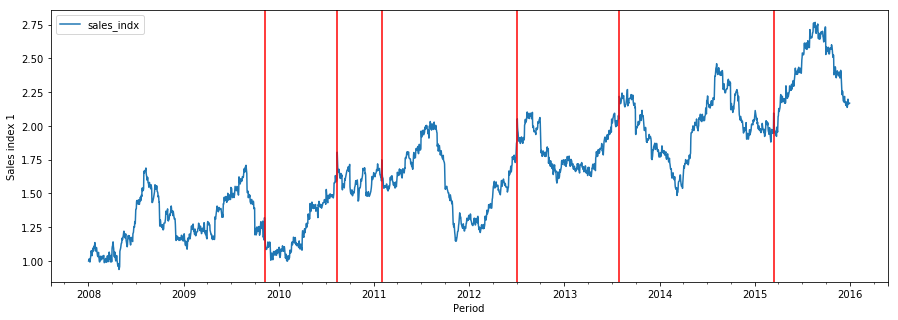

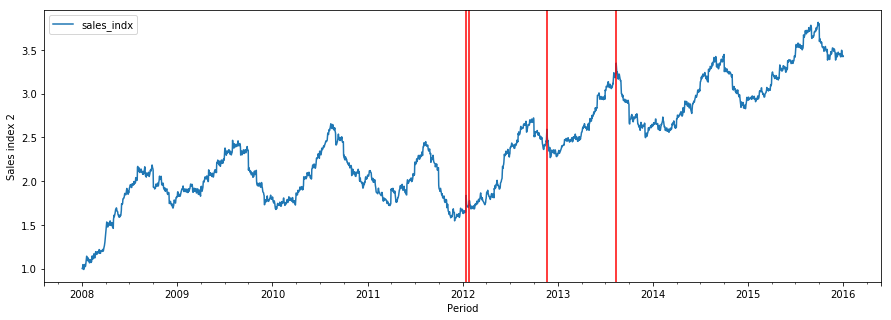

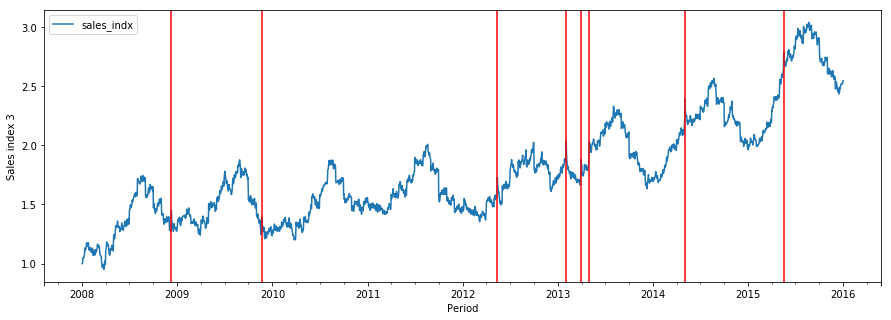

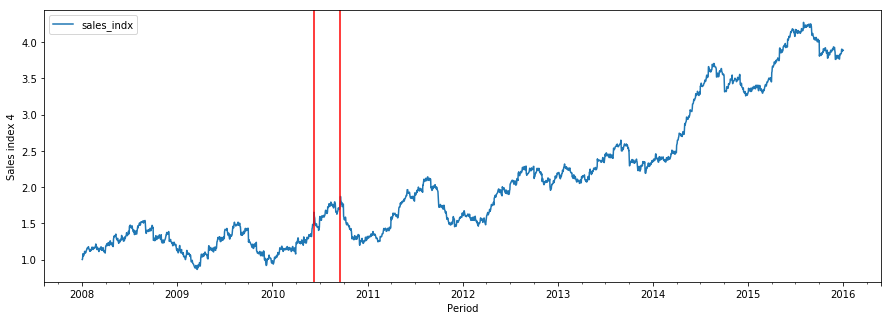

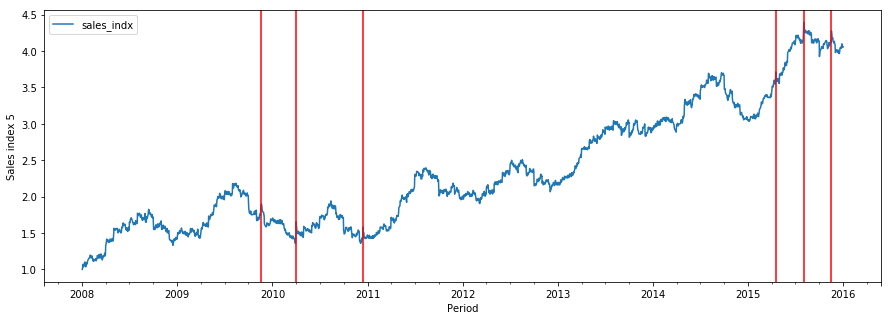

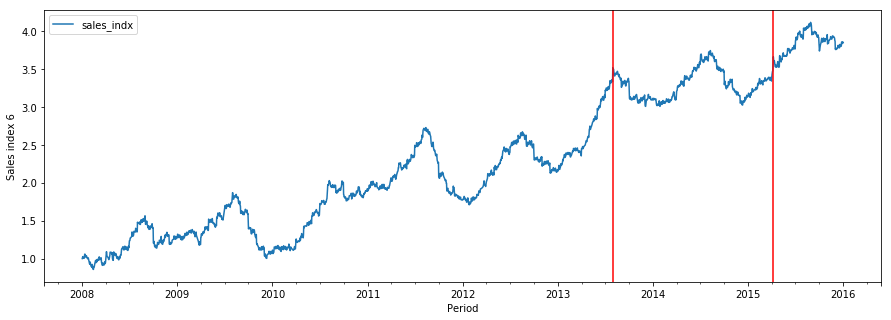

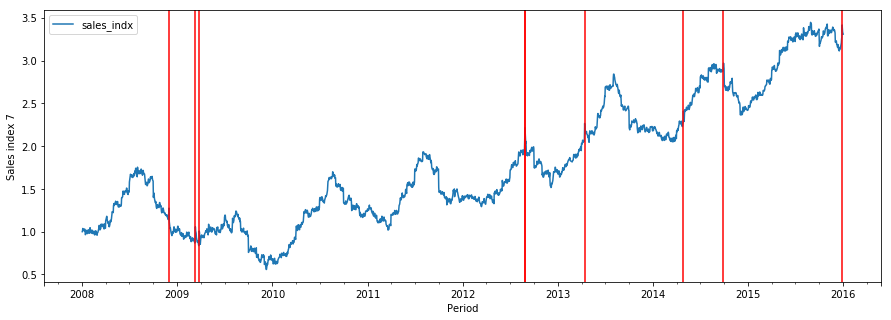

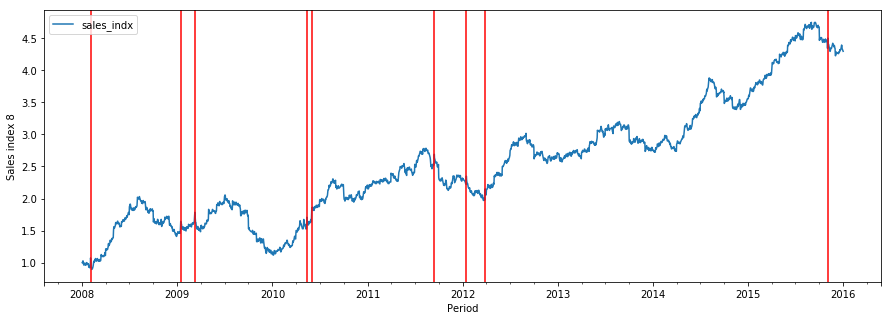

In [14]:
for market in train.market.unique():
    train[(train.market == market)].plot(x = 'date', y = 'sales_indx', figsize=(15,5))
    for date in train[(train.market == market) & (train.advert == 1)].date:
        plt.axvline(x = date, color='r')
    plt.xlabel('Period')
    plt.ylabel('Sales index {}'.format(market))
plt.show()

Результаты анализа:
- Выбросов на графике не замечено
- Акции приходятся на локальные всплески индекса продаж
- В индексе продаж прослеживается возрастающий тренд
- В индексе продаж заметна сезонность в рамках года (падение индекса в начале/конце года и рост в середине)

## 3. Построение новых признаков
Для удобства работы с данными объединим тестовые и обучающие выборки:

In [15]:
data = pd.concat([train.drop(['sales_indx'], axis=1),test], axis=0)
data.shape

(29200, 3)

Построим новые признаки на основании данных столбца date: 
- year_day_num - порядковый день в году
- month - месяц в году
- year -  год
- week_day_num - порядковый день недели
- weekend - выходной
- year_week_num - порядковый номер недели в году
- season - 1 - зима, 2- весна, 3 - лето, 4 - осень
- after_last_promo - количество месяцев после последней акции

In [16]:
%%time
data['year_day_num'] = data.date.dt.dayofyear
data['month'] = data.date.dt.month
data['year'] = data.date.dt.year
data['week_day_num'] = data.date.dt.dayofweek
data['weekend'] = ((data.date.dt.dayofweek) // 5 == 1).astype(int)
data['year_week_num'] = data.date.dt.weekofyear
data['season'] = (data.date.dt.month%12 + 3)//3

Wall time: 58.1 ms


Добавим количество месяцев между акциями, при этом в связи с тем, что о проведении акций до начала наблюдений за магазинами ничего не известно, примем, что последняя акция проводилась во всех магазинах за день до начала наблюдений (начало наблюдений по всем магазинам 2 января 2008 года):

In [17]:
%%time

def get_month_qty(start, end):
    from dateutil.relativedelta import relativedelta
    
    count = 0
    while start < end:
        start += relativedelta(months=+1)
        count += 1
    if count == 0:
        return count
    return count-1


data['after_last_promo'] = 0
for market in data.market.unique():
    last_promo = pd.to_datetime('2008-01-01')
    for date in data[(data.market == market)].date.sort_values(ascending = True):
        if data[(data.market == market) & (data.date == date)].advert.any() == 1:
            last_promo = date
        data['after_last_promo'][(data.market == market) & (data.date == date)] = get_month_qty(last_promo, date)        

Wall time: 26min 37s


В течение исследуемого периода имеется только один случай, когда в магазинах акции проводились одновременно, поэтому отдельный параметр, указывающий на одновременное проведение акций вводить не будем. Данные проверялись с помощью SQL:
   
- SELECT *, market_1+market_2+market_3+market_4+market_5+market_6+market_7+market_8 AS "Total"
- FROM [dbo].[advert_train]
- where market_1+market_2+market_3+market_4+market_5+market_6+market_7+market_8 > 0

Проверим, как выглядят полученные данные:

In [18]:
data.head(10)

,date,market,advert,year_day_num,month,year,week_day_num,weekend,year_week_num,season,after_last_promo
0,2008-01-02,1,0,2,1,2008,2,0,1,1,0
1,2008-01-03,1,0,3,1,2008,3,0,1,1,0
2,2008-01-04,1,0,4,1,2008,4,0,1,1,0
3,2008-01-05,1,0,5,1,2008,5,1,1,1,0
4,2008-01-06,1,0,6,1,2008,6,1,1,1,0
5,2008-01-07,1,0,7,1,2008,0,0,2,1,0
6,2008-01-08,1,0,8,1,2008,1,0,2,1,0
7,2008-01-09,1,0,9,1,2008,2,0,2,1,0
8,2008-01-10,1,0,10,1,2008,3,0,2,1,0
9,2008-01-11,1,0,11,1,2008,4,0,2,1,0


## 4. Корреляционный анализ признаков

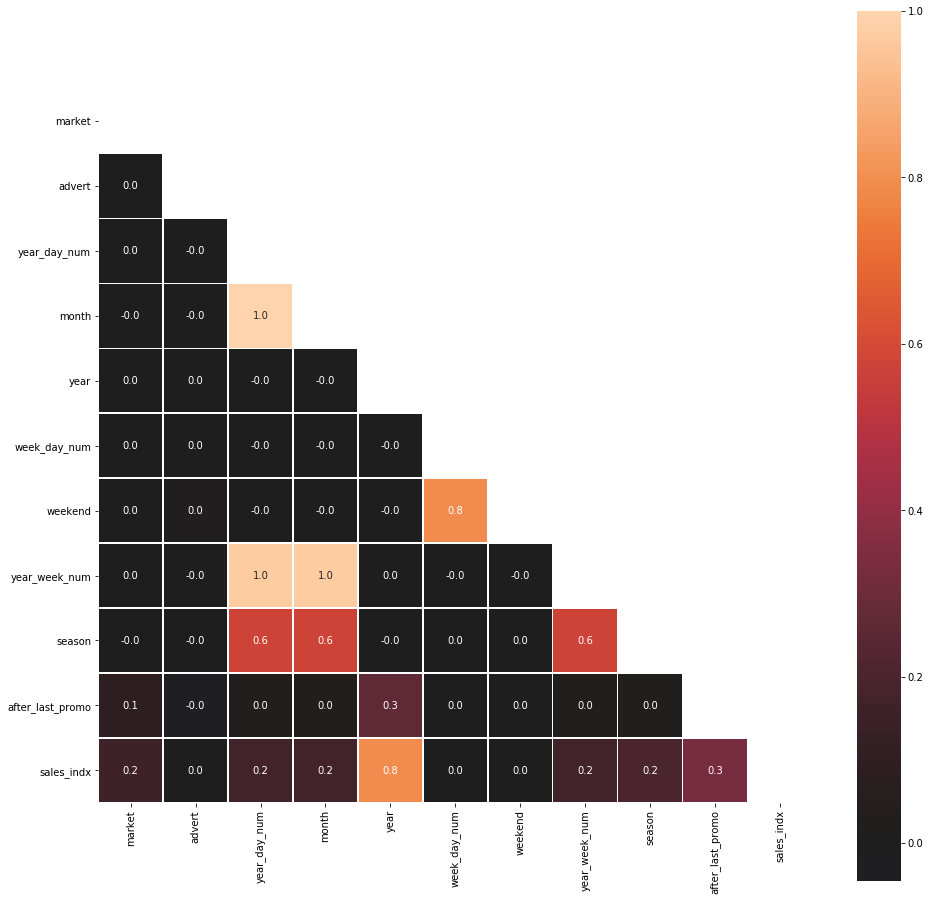

In [19]:
corr_df = data.iloc[:train.shape[0]]
corr_df['sales_indx'] = train['sales_indx']
corr = corr_df.corr(method='pearson')

# Генерируем маску для отсечения верхней диагонали матрицы
mask = np.zeros_like(corr, dtype=np.bool)

# Верхнему треугольнику присваиваем True
mask[np.triu_indices_from(mask)] = True 

plt.figure(figsize=(16,16))
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": 1});

Результаты исследования:
- Матрица корреляций по Пирсону показывает пары признаков с высокой корреляцией (чем ближе к единице, тем более высокая линейная зависимость в паре показателей между собой). Корреляция, в свою очередь, приводит к риску переобучения линейной модели. Для исключения линейной зависимости, и, как следствие, снижения риска переобучения модели, необходимо избавиться от одного из признаков в каждой подобной паре
- При этом линейные модели в такущей задаче могут плохо работать из-за сезонности в характере поведения индекса продаж. Если бы линейная модель была основной, то можно было избавиться от следующих признаков: **'month', 'year'**
- Также из корреляционной матрицы видно признак **'year'** имеют существенную положительную корреляцию с целевой переменной sales_indx - это вносит дополнительный риск переобучения модели

## 5. Выбор и обучение модели
Для прогнозирования индекса продаж мной были выбраны модели: 
- LinearRegression,
- RandomForestRegressor,
- GradientBoosting

Вводные данные к обучению модели:
- В обучении модели не используем признаки: 'year', 'month', так как они коррелируют с другими показателями и/или целевой переменной
- Массив обучающих данных делим на тестовую и обучающую выборки в соотношении 3/7 (30% - тестовая, 70% - обучающая)
- В процессе кросс-валидации полученный подмассив обучающих данных дополнительно делим на обучающую и валидационную выборки с помощью KFold с перемешиванием

In [37]:
RANDOM_STATE = 25

X_train, X_test, y_train, y_test = train_test_split(data.drop(['year', 'month'], axis = 1).iloc[:train.shape[0], 1:], 
                                                    train['sales_indx'], 
                                                    test_size = 0.3, random_state=RANDOM_STATE)
test = data.drop(['year', 'month'], axis = 1).iloc[train.shape[0]:, 1:]

In [38]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, test.shape

((16357, 8), (16357,), (7011, 8), (7011,), (5832, 8))

### RandomForestRegressor

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import explained_variance_score

In [47]:
#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) 
k_fold = KFold(len(y_train), shuffle=True, random_state=RANDOM_STATE)

n_estimators = range(10,131, 40)
max_depth_values = range(5, 20, 5)
max_features_values = range(4, 9)

tree_params = {
    #'n_estimators': n_estimators,
       #         'max_depth': max_depth_values,
               'max_features': max_features_values}

In [23]:
RFR = RandomForestRegressor(random_state=RANDOM_STATE)

In [51]:
%%time

RFR_grid = GridSearchCV(RFR, tree_params, scoring='explained_variance', cv = k_fold, n_jobs=-1).fit(X_train, y_train)

Wall time: 4h 22min 12s


In [49]:
RFR_grid.best_score_, RFR_grid.best_params_

(1.0, {'max_features': 4})

In [52]:
explained_variance_score(y_test, RFR_grid.predict(X_test))

0.8963290854281041

- Случайный лес работает  долго на таком объеме данных.
- Проверим с помощью линейной модели LASSO значимость признаков и затем попробуем применить отобранные значимые признаки на базовой модели случайного леса.

In [77]:
RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x00000000032D55D0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000000032D55D0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    494         if self.poller is not None:
    495             self.poller.start()
    496         self.kernel.start()
    497         self.io_loop = ioloop.IOLoop.current()
    498         try:
--> 499             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    500         except KeyboardInterrupt:
    501             pass
    502 
    503 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
C:\ProgramData\Anaconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    518         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    519                                finalizer=self._asyncgen_finalizer_hook)
    520         try:
    521             events._set_running_loop(self)
    522             while True:
--> 523                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    524                 if self._stopping:
    525                     break
    526         finally:
    527             self._stopping = False

...........................................................................
C:\ProgramData\Anaconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1753                         logger.warning('Executing %s took %.3f seconds',
   1754                                        _format_handle(handle), dt)
   1755                 finally:
   1756                     self._current_handle = None
   1757             else:
-> 1758                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(464, 1)>>
   1759         handle = None  # Needed to break cycles when an exception occurs.
   1760 
   1761     def _set_coroutine_origin_tracking(self, enabled):
   1762         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
C:\ProgramData\Anaconda3\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(464, 1)>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (464, 1)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=464, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 16, 6, 59, 20, 323334, tzinfo=tzutc()), 'msg_id': '532e40586c5c4045870346299a5a9351', 'msg_type': 'execute_request', 'session': 'e28341c638db4ad9970ef92a3d9138ac', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '532e40586c5c4045870346299a5a9351', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'e28341c638db4ad9970ef92a3d9138ac']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 16, 6, 59, 20, 323334, tzinfo=tzutc()), 'msg_id': '532e40586c5c4045870346299a5a9351', 'msg_type': 'execute_request', 'session': 'e28341c638db4ad9970ef92a3d9138ac', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '532e40586c5c4045870346299a5a9351', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'e28341c638db4ad9970ef92a3d9138ac'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 16, 6, 59, 20, 323334, tzinfo=tzutc()), 'msg_id': '532e40586c5c4045870346299a5a9351', 'msg_type': 'execute_request', 'session': 'e28341c638db4ad9970ef92a3d9138ac', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '532e40586c5c4045870346299a5a9351', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-77-58ac35bb2822>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 19de979b0, execution_...rue silent=False shell_futures=True> result=None>)
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])
   2906                 code = compiler(mod, cell_name, "single")
-> 2907                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000000000E759ED0, file "<ipython-input-77-58ac35bb2822>", line 1>
        result = <ExecutionResult object at 19de979b0, execution_...rue silent=False shell_futures=True> result=None>
   2908                     return True
   2909 
   2910             # Flush softspace
   2911             if softspace(sys.stdout, 0):

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000000000E759ED0, file "<ipython-input-77-58ac35bb2822>", line 1>, result=<ExecutionResult object at 19de979b0, execution_...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000000000E759ED0, file "<ipython-input-77-58ac35bb2822>", line 1>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
C:\Users\Гольский ВН\Desktop\Yandex\S7\DS_task\<ipython-input-77-58ac35bb2822> in <module>()
----> 1 RFR_grid.fit(X_train.iloc[:, [0, 1, 2, 3]], y_train)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=KFold(n_splits=16357, random_sta..., scoring='explained_variance',
       verbose=0), X=       market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns], y=10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64, groups=None, **fit_params={})
    635                                   return_train_score=self.return_train_score,
    636                                   return_n_test_samples=True,
    637                                   return_times=True, return_parameters=False,
    638                                   error_score=self.error_score)
    639           for parameters, (train, test) in product(candidate_params,
--> 640                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=16357, random_state=25, shuffle=True)>
        X =        market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns]
        y = 10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64
        groups = None
    641 
    642         # if one choose to see train score, "out" will contain train score info
    643         if self.return_train_score:
    644             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Nov 16 10:39:55 2018
PID: 3088                 Python 3.7.0: C:\ProgramData\Anaconda3\python.exe
...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False),        market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns], 10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64, {'score': make_scorer(explained_variance_score)}, array([    0,     1,     2, ..., 16354, 16355, 16356]), array([10118]), 0, {'max_features': 5}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False),        market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns], 10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64, {'score': make_scorer(explained_variance_score)}, array([    0,     1,     2, ..., 16354, 16355, 16356]), array([10118]), 0, {'max_features': 5})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), X=       market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns], y=10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64, scorer={'score': make_scorer(explained_variance_score)}, train=array([    0,     1,     2, ..., 16354, 16355, 16356]), test=array([10118]), verbose=0, parameters={'max_features': 5}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestRegr...tate=25,
           verbose=0, warm_start=False)>
        X_train =        market  advert  year_day_num  week_day_nu...       47             1

[16356 rows x 4 columns]
        y_train = 10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16356, dtype: float64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), X=array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), y=array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 9
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    774         self.n_completed_tasks = 0
    775         try:
    776             # Only set self._iterating to True if at least a batch
    777             # was dispatched. In particular this covers the edge
    778             # case of Parallel used with an exhausted iterator.
--> 779             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object BaseForest.fit.<locals>.<genexpr>>
    780                 self._iterating = True
    781             else:
    782                 self._iterating = False
    783 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object BaseForest.fit.<locals>.<genexpr>>)
    620             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    621             if len(tasks) == 0:
    622                 # No more tasks available in the iterator: tell caller to stop.
    623                 return False
    624             else:
--> 625                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    626                 return True
    627 
    628     def _print(self, msg, msg_args):
    629         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    583         self.n_dispatched_tasks += len(batch)
    584         self.n_dispatched_batches += 1
    585 
    586         dispatch_timestamp = time.time()
    587         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 588         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    589         self._jobs.append(job)
    590 
    591     def dispatch_next(self):
    592         """Dispatch more data for parallel processing

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    106             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    107         return 1
    108 
    109     def apply_async(self, func, callback=None):
    110         """Schedule a func to be run"""
--> 111         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    112         if callback:
    113             callback(result)
    114         return result
    115 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    327 
    328 class ImmediateResult(object):
    329     def __init__(self, batch):
    330         # Don't delay the application, to avoid keeping the input
    331         # arguments in memory
--> 332         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    333 
    334     def get(self):
    335         return self.results
    336 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), None, 0, 10), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), None, 0, 10)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in _parallel_build_trees(tree=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), forest=RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), X=array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), y=array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), sample_weight=None, tree_idx=0, n_trees=10, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeRegressor.fit of Decis...False, random_state=1589671044, splitter='best')>
        X = array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32)
        y = array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]])
        sample_weight = None
        curr_sample_weight = array([0., 1., 2., ..., 0., 0., 1.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), X=array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), y=array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), sample_weight=array([0., 1., 2., ..., 0., 0., 1.]), check_input=False, X_idx_sorted=None)
   1119 
   1120         super(DecisionTreeRegressor, self).fit(
   1121             X, y,
   1122             sample_weight=sample_weight,
   1123             check_input=check_input,
-> 1124             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
   1125         return self
   1126 
   1127 
   1128 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), X=array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), y=array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), sample_weight=array([0., 1., 2., ..., 0., 0., 1.]), check_input=False, X_idx_sorted=None)
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")
    241         if not (0 < max_features <= self.n_features_):
--> 242             raise ValueError("max_features must be in (0, n_features]")
    243         if not isinstance(max_leaf_nodes, (numbers.Integral, np.integer)):
    244             raise ValueError("max_leaf_nodes must be integral number but was "
    245                              "%r" % max_leaf_nodes)
    246         if -1 < max_leaf_nodes < 2:

ValueError: max_features must be in (0, n_features]
___________________________________________________________________________

In [75]:
from itertools import combinations
columns_feat = combinations(range(X_train.shape[1]), RFR_grid.best_params_['max_features'])

scores = []
columns_names = []
for elem in columns_feat:
    RFR_grid.fit(X_train.iloc[:, list(elem)], y_train)
    columns_names.append(X_train.iloc[:, list(elem)].columns)
    scores.append(explained_variance_score(y_test, RFR_grid.predict(X_test.iloc[:, list(elem)])))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x00000000032D55D0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000000032D55D0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    494         if self.poller is not None:
    495             self.poller.start()
    496         self.kernel.start()
    497         self.io_loop = ioloop.IOLoop.current()
    498         try:
--> 499             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    500         except KeyboardInterrupt:
    501             pass
    502 
    503 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
C:\ProgramData\Anaconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    518         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    519                                finalizer=self._asyncgen_finalizer_hook)
    520         try:
    521             events._set_running_loop(self)
    522             while True:
--> 523                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    524                 if self._stopping:
    525                     break
    526         finally:
    527             self._stopping = False

...........................................................................
C:\ProgramData\Anaconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1753                         logger.warning('Executing %s took %.3f seconds',
   1754                                        _format_handle(handle), dt)
   1755                 finally:
   1756                     self._current_handle = None
   1757             else:
-> 1758                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(464, 1)>>
   1759         handle = None  # Needed to break cycles when an exception occurs.
   1760 
   1761     def _set_coroutine_origin_tracking(self, enabled):
   1762         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
C:\ProgramData\Anaconda3\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(464, 1)>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (464, 1)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=464, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 16, 5, 24, 51, 437719, tzinfo=tzutc()), 'msg_id': '44b51da647b0429fbc0d5da1f7106f9c', 'msg_type': 'execute_request', 'session': 'e28341c638db4ad9970ef92a3d9138ac', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '44b51da647b0429fbc0d5da1f7106f9c', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'e28341c638db4ad9970ef92a3d9138ac']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 16, 5, 24, 51, 437719, tzinfo=tzutc()), 'msg_id': '44b51da647b0429fbc0d5da1f7106f9c', 'msg_type': 'execute_request', 'session': 'e28341c638db4ad9970ef92a3d9138ac', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '44b51da647b0429fbc0d5da1f7106f9c', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'e28341c638db4ad9970ef92a3d9138ac'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 11, 16, 5, 24, 51, 437719, tzinfo=tzutc()), 'msg_id': '44b51da647b0429fbc0d5da1f7106f9c', 'msg_type': 'execute_request', 'session': 'e28341c638db4ad9970ef92a3d9138ac', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '44b51da647b0429fbc0d5da1f7106f9c', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from itertools import combinations\ncolumns_feat ...t, RFR_grid.predict(X_test.iloc[:, list(elem)])))', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-75-0ac3d28a8cde>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 19bc97be0, execution_...rue silent=False shell_futures=True> result=None>)
   2896             raise ValueError("Interactivity was %r" % interactivity)
   2897         try:
   2898             for i, node in enumerate(to_run_exec):
   2899                 mod = ast.Module([node])
   2900                 code = compiler(mod, cell_name, "exec")
-> 2901                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000000000E759E40, file "<ipython-input-75-0ac3d28a8cde>", line 6>
        result = <ExecutionResult object at 19bc97be0, execution_...rue silent=False shell_futures=True> result=None>
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000000000E759E40, file "<ipython-input-75-0ac3d28a8cde>", line 6>, result=<ExecutionResult object at 19bc97be0, execution_...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000000000E759E40, file "<ipython-input-75-0ac3d28a8cde>", line 6>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
C:\Users\Гольский ВН\Desktop\Yandex\S7\DS_task\<ipython-input-75-0ac3d28a8cde> in <module>()
      2 columns_feat = combinations(range(X_train.shape[1]), RFR_grid.best_params_['max_features'])
      3 
      4 scores = []
      5 columns_names = []
      6 for elem in columns_feat:
----> 7     RFR_grid.fit(X_train.iloc[:, list(elem)], y_train)
      8     columns_names.append(X_train.iloc[:, list(elem)].columns)
      9     scores.append(explained_variance_score(y_test, RFR_grid.predict(X_test.iloc[:, list(elem)])))

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=KFold(n_splits=16357, random_sta..., scoring='explained_variance',
       verbose=0), X=       market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns], y=10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64, groups=None, **fit_params={})
    635                                   return_train_score=self.return_train_score,
    636                                   return_n_test_samples=True,
    637                                   return_times=True, return_parameters=False,
    638                                   error_score=self.error_score)
    639           for parameters, (train, test) in product(candidate_params,
--> 640                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=16357, random_state=25, shuffle=True)>
        X =        market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns]
        y = 10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64
        groups = None
    641 
    642         # if one choose to see train score, "out" will contain train score info
    643         if self.return_train_score:
    644             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Fri Nov 16 09:05:02 2018
PID: 3312                 Python 3.7.0: C:\ProgramData\Anaconda3\python.exe
...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False),        market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns], 10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64, {'score': make_scorer(explained_variance_score)}, array([    0,     1,     2, ..., 16354, 16355, 16356]), array([10118]), 0, {'max_features': 5}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False),        market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns], 10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64, {'score': make_scorer(explained_variance_score)}, array([    0,     1,     2, ..., 16354, 16355, 16356]), array([10118]), 0, {'max_features': 5})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), X=       market  advert  year_day_num  week_day_nu...       47             1

[16357 rows x 4 columns], y=10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16357, dtype: float64, scorer={'score': make_scorer(explained_variance_score)}, train=array([    0,     1,     2, ..., 16354, 16355, 16356]), test=array([10118]), verbose=0, parameters={'max_features': 5}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestRegr...tate=25,
           verbose=0, warm_start=False)>
        X_train =        market  advert  year_day_num  week_day_nu...       47             1

[16356 rows x 4 columns]
        y_train = 10716    2.180874
8126     2.046109
14368    3.7...8
Name: sales_indx, Length: 16356, dtype: float64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in fit(self=RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), X=array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), y=array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), sample_weight=None)
    323             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    324                              backend="threading")(
    325                 delayed(_parallel_build_trees)(
    326                     t, self, X, y, sample_weight, i, len(trees),
    327                     verbose=self.verbose, class_weight=self.class_weight)
--> 328                 for i, t in enumerate(trees))
        i = 9
    329 
    330             # Collect newly grown trees
    331             self.estimators_.extend(trees)
    332 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    774         self.n_completed_tasks = 0
    775         try:
    776             # Only set self._iterating to True if at least a batch
    777             # was dispatched. In particular this covers the edge
    778             # case of Parallel used with an exhausted iterator.
--> 779             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object BaseForest.fit.<locals>.<genexpr>>
    780                 self._iterating = True
    781             else:
    782                 self._iterating = False
    783 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object BaseForest.fit.<locals>.<genexpr>>)
    620             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    621             if len(tasks) == 0:
    622                 # No more tasks available in the iterator: tell caller to stop.
    623                 return False
    624             else:
--> 625                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    626                 return True
    627 
    628     def _print(self, msg, msg_args):
    629         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    583         self.n_dispatched_tasks += len(batch)
    584         self.n_dispatched_batches += 1
    585 
    586         dispatch_timestamp = time.time()
    587         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 588         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    589         self._jobs.append(job)
    590 
    591     def dispatch_next(self):
    592         """Dispatch more data for parallel processing

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    106             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    107         return 1
    108 
    109     def apply_async(self, func, callback=None):
    110         """Schedule a func to be run"""
--> 111         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    112         if callback:
    113             callback(result)
    114         return result
    115 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    327 
    328 class ImmediateResult(object):
    329     def __init__(self, batch):
    330         # Don't delay the application, to avoid keeping the input
    331         # arguments in memory
--> 332         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    333 
    334     def get(self):
    335         return self.results
    336 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), None, 0, 10), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), None, 0, 10)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py in _parallel_build_trees(tree=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), forest=RandomForestRegressor(bootstrap=True, criterion=...state=25,
           verbose=0, warm_start=False), X=array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), y=array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), sample_weight=None, tree_idx=0, n_trees=10, verbose=0, class_weight=None)
    116                 warnings.simplefilter('ignore', DeprecationWarning)
    117                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    118         elif class_weight == 'balanced_subsample':
    119             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    120 
--> 121         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeRegressor.fit of Decis...False, random_state=1589671044, splitter='best')>
        X = array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32)
        y = array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]])
        sample_weight = None
        curr_sample_weight = array([0., 1., 2., ..., 0., 0., 1.])
    122     else:
    123         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    124 
    125     return tree

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), X=array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), y=array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), sample_weight=array([0., 1., 2., ..., 0., 0., 1.]), check_input=False, X_idx_sorted=None)
   1119 
   1120         super(DecisionTreeRegressor, self).fit(
   1121             X, y,
   1122             sample_weight=sample_weight,
   1123             check_input=check_input,
-> 1124             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
   1125         return self
   1126 
   1127 
   1128 class ExtraTreeClassifier(DecisionTreeClassifier):

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\tree.py in fit(self=DecisionTreeRegressor(criterion='mse', max_depth...=False, random_state=1589671044, splitter='best'), X=array([[  4.,   0., 128.,   2.],
       [  3.,  ...
       [  3.,   0.,  47.,   1.]], dtype=float32), y=array([[2.18087425],
       [2.04610924],
      ...061 ],
       [1.0338749 ],
       [1.36479827]]), sample_weight=array([0., 1., 2., ..., 0., 0., 1.]), check_input=False, X_idx_sorted=None)
    237         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    238             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    239         if max_depth <= 0:
    240             raise ValueError("max_depth must be greater than zero. ")
    241         if not (0 < max_features <= self.n_features_):
--> 242             raise ValueError("max_features must be in (0, n_features]")
    243         if not isinstance(max_leaf_nodes, (numbers.Integral, np.integer)):
    244             raise ValueError("max_leaf_nodes must be integral number but was "
    245                              "%r" % max_leaf_nodes)
    246         if -1 < max_leaf_nodes < 2:

ValueError: max_features must be in (0, n_features]
___________________________________________________________________________

In [ ]:
scores_dict = zip(columns_names, scores)

print([columns for columns, scores in scores_dict.items() if scores = max(scores_dict.values)])

### Масштабирование признаков

In [54]:
# Вещественные признаки
scaler = StandardScaler()
X_full = scaler.fit_transform(data[real_features+categor_features])
X_full.shape

(2069185, 29)

In [55]:
# Бинарные признаки
X_full = np.concatenate((X_full,data[bin_features].values), axis=1)
X_full.shape

(2069185, 31)

In [61]:
X=X_full[:1444051]
X_tst = X_full[1444051:]
y = target.values
X.shape, y.shape, X_tst.shape

((1444051, 31), (1444051,), (625134, 31))

In [62]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_scaled_train.shape, X_scaled_test.shape, y_train.shape, y_test.shape

((1010835, 31), (433216, 31), (1010835,), (433216,))

### Линейная модель
#### Анализ значимости признаков с помощью модели Lasso

In [63]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

In [64]:
%%time
lasso = LassoCV(cv = kfold, n_jobs=-1)
lasso.fit(X_scaled_train, y_train)

CPU times: user 25 s, sys: 11.1 s, total: 36.1 s
Wall time: 39.3 s


In [65]:
mean_absolute_error(y_test, lasso.predict(X_scaled_test))

294.50634775795231

In [66]:
feature_names = real_features + categor_features + bin_features

In [67]:
# Функция, возвращающая веса линейной модели, убывающие по абсолютному значению
def getCoefficients(model):    
    coefs = pd.DataFrame(model.coef_, feature_names)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

In [68]:
getCoefficients(lasso)

,coef
distance_haversine,312.085795
dest_cluster_mean,46.558004
pickup_cluster_mean,45.904874
dweek_mean,29.965103
new_dyear_mean,17.172992
center_latitude,-6.281487
hour,5.164692
manhattan,4.031976
cos_dist,0.000000
vendor_id,0.000000


In [69]:
good_features = ['distance_haversine', 'dest_cluster_mean', 'pickup_cluster_mean', 'dweek_mean', 
                 'new_dyear_mean', 'hour', 'center_latitude', 'manhattan']

### Проверим как изменилась ошибка базового случайного леса на отобранных значимых признаках good_features

In [11]:
X_full = data[good_features].values
X=X_full[:1444051]
X_tst = X_full[1444051:]
y = target.values
# Разобъем выборку на обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                     random_state=RANDOM_STATE)

In [14]:
%%time
rf = RandomForestRegressor(n_estimators = 30,
                           max_depth = 10,
                           random_state=RANDOM_STATE)
mean_score = cross_val_score(rf, X_train, y_train, cv=kfold, n_jobs=-1, scoring = 'neg_mean_absolute_error').mean()
print ('mae: {}'.format(mean_score))

mae: -205.37410133601458
CPU times: user 1.02 s, sys: 168 ms, total: 1.19 s
Wall time: 4min 41s


- Lasso метод выкинул значащие признаки, так как MAE повысилась после обучения на неполной выборке. 

### Попробуем улучшить качество за счет фильтрация выбросов некоторых признаков
- Заменим едианными значениями выбросы по координатам

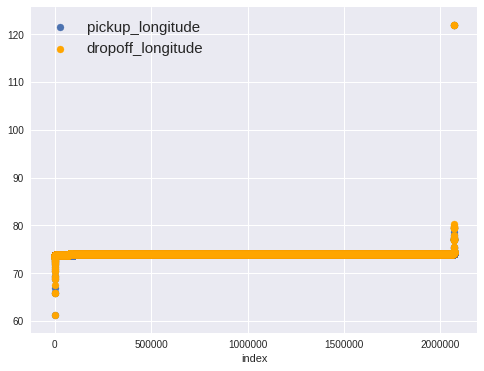

In [37]:
plt.figure(figsize=(8,6))
plt1 = plt.scatter(range(data.shape[0]), np.sort(data['pickup_longitude'].apply(np.abs)))
plt2 = plt.scatter(range(data.shape[0]), np.sort(data['dropoff_longitude'].apply(np.abs)), color='orange')
plt.xlabel('index')
plt.legend([plt1, plt2], ['pickup_longitude', 'dropoff_longitude'], fontsize=15);

In [38]:
data.at[data['pickup_longitude'] < -85.0, 'pickup_longitude'] = data['pickup_longitude'].median()
data.at[data['dropoff_longitude'] < -85.0, 'dropoff_longitude'] = data['pickup_longitude'].median()

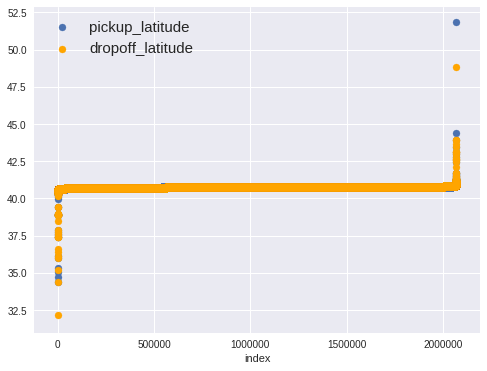

In [39]:
plt.figure(figsize=(8,6))
plt1 = plt.scatter(range(data.shape[0]), np.sort(data['pickup_latitude']))
plt2 = plt.scatter(range(data.shape[0]), np.sort(data['dropoff_latitude']), color='orange') 
plt.xlabel('index')
plt.legend([plt1, plt2], ['pickup_latitude', 'dropoff_latitude'], fontsize=15);

In [40]:
data.at[data['pickup_latitude'] > 45.0, 'pickup_latitude'] = data['pickup_latitude'].median()
data.at[data['dropoff_latitude'] > 45.0, 'dropoff_latitude'] = data['dropoff_latitude'].median()

#### Обучим базовую модель RandomForest на отфильтрованных данных

In [43]:
feature_names = real_features + categor_features + bin_features

In [45]:
X_full = data[feature_names].values
X=X_full[:1444051]
X_tst = X_full[1444051:]
y = target.values
# Разобъем выборку на обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                     random_state=RANDOM_STATE)

In [48]:
%%time
rf = RandomForestRegressor(n_estimators = 30,
                           max_depth = 10,
                           random_state=RANDOM_STATE)
mean_score = cross_val_score(rf, X_train, y_train, cv=kfold, n_jobs=-1, scoring = 'neg_mean_absolute_error').mean()
print ('mae: {}'.format(mean_score))

mae: -202.4213366353691
CPU times: user 3.98 s, sys: 420 ms, total: 4.4 s
Wall time: 19min 53s


- Ошибка практически не изменилась по сравнению с результатом на неотфильтрованных данных (mae: -202.35252728664412)

### LightGBM
- Попробуем улучшить результат за счет применения градиентного бустинга
- Будем использовать реализацию бустинга от Microsoft - LightGBM, которая значительно быстрее традиционного XGBoost. Использование быстрой модели позволит обучать множество вариантов моделей с различными гиперпапраметрами и усреднять результаты.

In [71]:
real_features = ['passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'hour', #'dyear', #'dweek',
       'weekofyear', 'minute', 'week_hour', 'dt', 'dweek_pass_count',
                'pickup_pca0', 'pickup_pca1',
       'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'cos_dist',
       'manhattan', 'center_latitude', 'center_longitude', 'pca_manhattan', 
       'average temperature', 'precipitation', 'snow fall', 'snow depth'
                ]
categor_features = ['pickup_cluster_mean', 'dest_cluster_mean', 'dweek_mean', 'new_dyear_mean']
bin_features = ['vendor_id','store_and_fwd_flag']

#### Деление выборки

In [72]:
feature_names = real_features + categor_features + bin_features
#feature_names = good_features

In [73]:
X_full = data[feature_names].values

In [74]:
X=X_full[:1444051]
X_tst = X_full[1444051:]
y = target.values
X.shape, y.shape, X_tst.shape

((1444051, 31), (1444051,), (625134, 31))

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                     random_state=7)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1010835, 31), (433216, 31), (1010835,), (433216,))

#### Модель LightGBM с праметрами по умолчанию

In [111]:
model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            objective='regression',
            nthread=-1
        )
model.fit(X_train, y_train)        
mae = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
print('MAE:{}'.format(mae))

MAE:265.562706614055


- Пока качество хуже случайного леса "из коробки".
- Но попробуем настроить гиперпараметры.

## 8. Настройка гиперпараметров модели с помошью библиотеки hyperopt
- Выборка очень большая, более 1 млн. строк, поэтому обойдемся без кросс-валидации. Валидироваться будем просто на отложенной выборке один раз.

In [50]:
from hyperopt import hp
from hyperopt import fmin, Trials, tpe

In [68]:
def hyperopt_objective(params):
    model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators = params['num_est'],
            max_depth = params['max_dpth'],
            num_leaves = params['num_lvs'],
            learning_rate = params['lrn_rate'],
            reg_alpha = params['reg_alph'],
            reg_lambda = params['reg_lmbd'],
            objective='regression',
            nthread=-1
        )    
    model.fit(X_train, y_train)
    mae = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
    return mae

In [70]:
params_space = {
    'num_est': hp.choice('num_est', (4000,4500,5000,5500,6000)), 
    'max_dpth': hp.choice('max_dpth', (30,33,35,38)),
    'num_lvs': hp.choice('num_lvs', (15,18,20,23,27)),
    'lrn_rate': hp.uniform('lrn_rate', 0.2, 0.4),
    'reg_alph': hp.uniform('reg_alph', 10, 50),
    'reg_lmbd': hp.uniform('reg_lmbd', 10, 50)
}

In [71]:
%%time
trials = Trials()
best_params = fmin(
    hyperopt_objective,
    space=params_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    verbose = 2
)

CPU times: user 1d 7h 35min 6s, sys: 1min 34s, total: 1d 7h 36min 41s
Wall time: 7h 58min 4s


In [72]:
best_params

{'lrn_rate': 0.2029823209429007,
 'max_dpth': 3,
 'num_est': 3,
 'num_lvs': 4,
 'reg_alph': 43.63743528388524,
 'reg_lmbd': 42.56637567284501}

In [105]:
# Сохраним лог hyperopt
with open('hyperopt_trials.pkl', 'wb') as hyp_trl:
    pickle.dump(trials.trials, hyp_trl)

#### Пример лога поиска оптимальных параметров с помощью hyperopt:

In [91]:
trials.trials[0]

{'book_time': datetime.datetime(2017, 11, 10, 19, 52, 50, 523000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'lrn_rate': [0],
   'max_dpth': [0],
   'num_est': [0],
   'num_lvs': [0],
   'reg_alph': [0],
   'reg_lmbd': [0]},
  'tid': 0,
  'vals': {'lrn_rate': [0.3057488956574924],
   'max_dpth': [1],
   'num_est': [3],
   'num_lvs': [2],
   'reg_alph': [40.69034076946591],
   'reg_lmbd': [13.034331279444196]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2017, 11, 10, 19, 57, 54, 863000),
 'result': {'loss': 157.39614957269134, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 0,
 'version': 0}

#### График ошибки на отложенной выборке, который показывает как hyperopt подбирал параметры

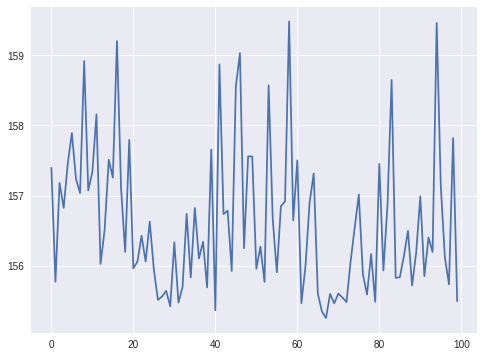

In [109]:
plt.figure(figsize=(8,6))
plt.plot(range(len(trials.losses())), trials.losses());

- Судя по графику поиск происходил случайным образом

In [107]:
min(trials.losses())

155.2550627993237

#### Обучение на оптимальных гиперпараметрах

In [63]:
model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=5500,
            max_depth=38,
            num_leaves=27,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
model.fit(X_train, y_train)        
mae = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
print('MAE:{}'.format(mae))

MAE:155.03589145692152


- Видим заметное улучшение качества прогнозирования за счет подбора потимальных гиперпараметров модели с помощью бибилиотеки hyperopt по сравнению с дeфолтной моделью lightgbm (MAE:265.562706614055)

## 9. Построение валидационных, тестовых и тренировочных кривых.
- Перебор 100 комбинаций гиперпараметров lightgbm занял около 8 часов. Столь длительное время объясняется главным образом количеством деревьев (от 4000 до 6000). Построение же кросс-валидационных кривых для такого количества деревьев может занять в несколько раз больше времени. Поэтому было принято решение построить валидационные кривые только для параметров 'max_dpth' и 'num_lvs' для 1000 деревьев, и оценить по ним как обучается модель.

In [64]:
kfold = KFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)

#### Кривые валидации, тестовая и тренировочная для разных значений параметра ***max_depth***

In [90]:
train_mae = []
valid_mae = []
test_mae = [] 
max_depth_grid = [10,40,60,80,100]

# Обучаем на тренировочном датасете
for depth in tqdm.tqdm_notebook(max_depth_grid):
    model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=1000,
            max_depth=depth,
            num_leaves=27,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
    temp_train_mae = []
    temp_valid_mae = []
    temp_test_mae = []
    for train_index, valid_index in kfold.split(X_train, y_train):
        X_trn, X_vld = X_train[train_index], X_train[valid_index]
        y_trn, y_vld = y_train[train_index], y_train[valid_index]
        model.fit(X_trn, y_trn)
        temp_train_mae.append(metrics.mean_absolute_error(y_trn, model.predict(X_trn)))
        temp_valid_mae.append(metrics.mean_absolute_error(y_vld, model.predict(X_vld)))
    train_mae.append(temp_train_mae)
    valid_mae.append(temp_valid_mae)
    test_mae.append(metrics.mean_absolute_error(y_valid, model.predict(X_valid)))


In [91]:
def plot_cv_trn_tst(train_mae, valid_mae, test_mae, grid, label):
    train_mae, valid_mae, test_mae = np.asarray(train_mae), np.asarray(valid_mae), np.asarray(test_mae)
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(grid, train_mae.mean(axis=1), alpha=0.5, color='blue', label='train')
    ax.plot(grid, valid_mae.mean(axis=1), alpha=0.5, color='red', label='cv')
    ax.fill_between(grid, valid_mae.mean(axis=1) - valid_mae.std(axis=1), valid_mae.mean(axis=1) + valid_mae.std(axis=1), color='#888888', alpha=0.4)
    ax.fill_between(grid, valid_mae.mean(axis=1) - 2*valid_mae.std(axis=1), valid_mae.mean(axis=1) + 2*valid_mae.std(axis=1), color='#888888', alpha=0.2)
    ax.plot(grid, test_mae, alpha=0.5, color='orange', label='test')
    ax.legend(loc='best', fontsize=15)
    #ax.set_ylim([0.88,1.02])
    ax.set_ylabel("MAE", fontsize=15)
    ax.set_xlabel(label, fontsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.set_title('CV, train, test-curves', fontsize=20);

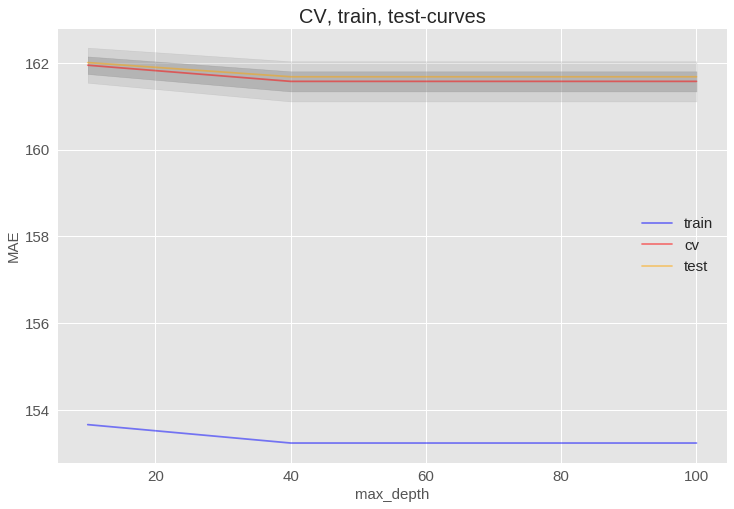

In [92]:
plot_cv_trn_tst(train_mae, valid_mae, test_mae, max_depth_grid, 'max_depth')

- Видно, что после  'max_depth' = 40 качество модели не улучшается. То есть, параметр, подобранный функцийе hyperopt является оптимальным.

#### Кривые валидации, тестовая и тренировочная для разных значений параметра ***num_leaves***

In [76]:
train_mae = []
valid_mae = []
test_mae = [] 
num_lvs_grid = [40,50,55,60,65]

# Обучаем на тренировочном датасете
for lvs in tqdm.tqdm_notebook(num_lvs_grid):
    model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=1000,
            max_depth=40,
            num_leaves=lvs,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
    temp_train_mae = []
    temp_valid_mae = []
    temp_test_mae = []
    for train_index, valid_index in kfold.split(X_train, y_train):
        X_trn, X_vld = X_train[train_index], X_train[valid_index]
        y_trn, y_vld = y_train[train_index], y_train[valid_index]
        model.fit(X_trn, y_trn)
        temp_train_mae.append(metrics.mean_absolute_error(y_trn, model.predict(X_trn)))
        temp_valid_mae.append(metrics.mean_absolute_error(y_vld, model.predict(X_vld)))
    train_mae.append(temp_train_mae)
    valid_mae.append(temp_valid_mae)
    test_mae.append(metrics.mean_absolute_error(y_valid, model.predict(X_valid)))


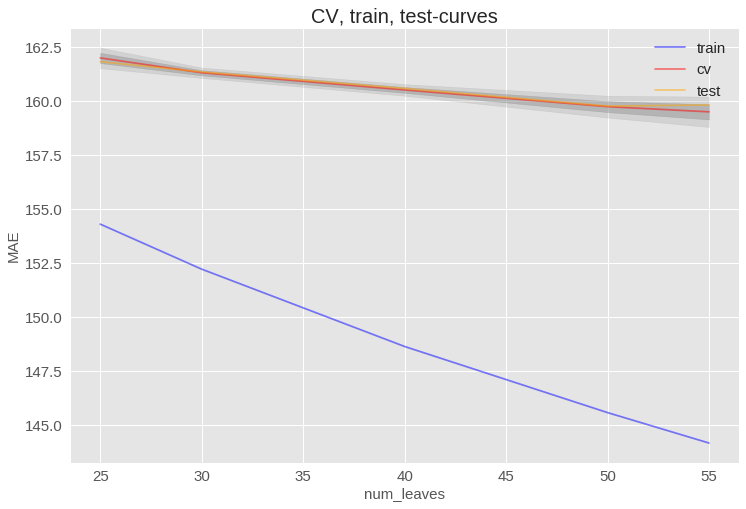

In [83]:
plot_cv_trn_tst(train_mae, valid_mae, test_mae, num_lvs_grid, 'num_leaves')

- Видно, что после значения параметра 'num_leaves' = 50 тестовая кривая перестает снижаться. Поэтому на этом значении 'num_leaves' стоит остановиться. 

#### Проверим качество модели на отложенной выборке с количеством деревьев, найденных с помощью hyperopt

In [76]:
model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=5500,
            max_depth=38,
            num_leaves=50,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
model.fit(X_train, y_train)        
mae = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
print('MAE:{}'.format(mae))

MAE:154.98340115188805


- Качество немного улучшилось без риска переобучения.
- Оставим эти гиперпараметры и попробуем применить Стекинг.

## 10. Стекинг
- Идея стекинга заключается в генерировании метапризнаков с помощью некоторой базовой модели и использование полученных метапризнаков совместно с основной выборкой в итоговой метамодели: [Методы ансамблирования обучающихся алгоритмов](http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf)
- В текущем проекте использовался модифицированный вариант стекинга, когда деление исходной выборки осуществлялось методом bootstrap.
- В качестве метамодели и основной модели использовалась LightGBM.
- Из-за большого объема исходных данных стекинг на большом количестве bootstrap-выборок занимает очень много времени на среднем по производительности PC. В то же время даже на трех bootstrap-выборках удалось добиться существенного снижения ошибки. 
- Во время обучения стекинг осуществлялся в 2 прохода для разных значений random_state, а полученные результаты 2-х моделей усреднялись. Такой подход также привел к снижению ошибки.

In [76]:
# Разбиение с помощью bootstrap
def get_bootstrap_samples(X, y, n_samples):  
    X_train_1 = []
    y_train_1 = []
    X_train_2 = []
    y_train_2 = []
    # генерируем матрицу индексов подвыборок из генеральной выборки
    indices = np.random.randint(0, y.size, (n_samples, y.size)) 
    # массив выборок
    j=0
    for i in range(int(n_samples/2)):
        X_train_1.append(X[indices[j]])
        y_train_1.append(y[indices[j]])
        X_train_2.append(X[indices[j+1]])
        y_train_2.append(y[indices[j+1]])  
        j += 2
    return X_train_1, y_train_1, X_train_2, y_train_2


In [77]:
# Модель LightGBM с предварительно настроенными гиперпараметрами
def lgbm_model():
    model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=5500,
            max_depth=38,
            num_leaves=27,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
    return model

In [78]:
KK = [3] # количество выборок bootstrap
y_pred_best = None
meta_mae_0 = inf

basic_mae = []
meta_mae = []
y_pred = []
seed = [42,7] # Варианты сидов
n_samples = len(seed)
for i in tqdm.tqdm_notebook(range(n_samples)):
    np.random.seed(seed[i])
    kk = KK[0] 
    X_train_1, y_train_1, X_train_2, y_train_2 = get_bootstrap_samples(X, y, kk*2)
    
    for k in tqdm.tqdm_notebook(range(kk)):
        # Обучим базовую модель на выборке X_train_1, y_train_1
        bst = lgbm_model()
        bst.fit(X_train_1[k], y_train_1[k])
                
        # make prediction
        basic_mae.append(metrics.mean_absolute_error(y_valid, bst.predict(X_valid)))   

        # Предсказание обученного алгоритма для выборок X_train_2 и X_valid. Метапризнаки
        MF2 = bst.predict(X_train_2[k])
        MF0 = bst.predict(X_valid)
        MF_tst = bst.predict(X_tst)

        # Получим новую обучающую выборку (объединим X_train_2 c метапризнаком MF2)
        new_train = np.concatenate((X_train_2[k],MF2.reshape(MF2.size, 1)), axis=1)

        # Получим новую валидационную выборку (объединим X_valid c метапризнаком MF0)
        new_valid = np.concatenate((X_valid,MF0.reshape(MF0.size, 1)), axis=1)

        # Получим новую тестовую выборку (объединим X_tst c метапризнаком MF_tst)
        new_tst = np.concatenate((X_tst,MF_tst.reshape(MF_tst.size, 1)), axis=1)

        # Обучим метамодель        
        meta_model = lgbm_model()
        meta_model.fit(new_train, y_train_2[k])

        meta_mae.append(metrics.mean_absolute_error(y_valid, meta_model.predict(new_valid)))
        
        y_pred.append(meta_model.predict(new_tst))

basic_mean = mean(basic_mae)
meta_mean = mean(meta_mae)

print ('basic_mean: {}, meta_mean: {}'.format(basic_mean, meta_mean))




basic_mean: 140.60101719388723, meta_mean: 123.96648039023809


In [122]:
print('{}%'.format(round((100*(155 - meta_mean)/155),0)))

20.0%


- Стекинг позволил снизить MAE на 20% (123.9) по сравнению с моделью LightGBM с просто настроенными параметрами.

### Подготовка данных для отправки на kaggle.com

In [80]:
predictions = np.vstack(y_pred).T
predictions = predictions.mean(axis=1)
test['trip_duration'] = predictions.astype(int)

In [81]:
# Проверка на NAN
test['trip_duration'].isnull().values.any()

False

In [83]:
test['trip_duration'] = test['trip_duration'].apply(lambda x: x*(-1) if x<0 else x)

In [84]:
# Load to csv
test[['id','trip_duration']].to_csv('submit_.csv', index=False)

#### Резултат на kaggle (метрика Root Mean Squared Logarithmic Error):
- Private score: 0.39744 

## 11. Выводы.
- В процессе анализа признаков было сгенерировано большое количество временных и гео-признаков. Анализ этих признаков позволяет получить много информации об особенностях транспортных пассажирских перевозках в исследуемой локации. То есть, помимо решенной задачи прогнозирования поездки, эта работа позволяет сделать выводы по дальнейшему улучшению качества поездок.
- Далеко не все признаки сделали существенный вклад в итоговый прогноз. Но это не всегда говорит о том, что признак бесполезен. Часто грамотное кодирование признака и применение подходящей модели позволяет извлечь из него много полезной информации.
- Настройка гиперапраметров модели LightGBM позволило получить результат существенно лучше случайного леса и линейных моделей.
- Применение технологии стекинга (обучение на метапризнаках) позволило снизить ошибку на 20% по сравнению с моделью, для которой осуществлялась только настройка параметров.
- Дальнейшее развитие модели:
    - Так как в задаче используются распределенные в пространстве данные, то можно представить признаковое пространство в виде геораспределенной сетки и применить сверточную сеть по аналогии с изображением.
    - Преимуществом такого подхода будет в том, что нейронная сеть сама будет выявлять дополнительные признаки и зависимости, что позволит уменьшить сложность подготовительной части проекта, связанной с анализом признаков.
    
    